# <font color="BLUEVIOLET"> QUANTITATIVE FORECASTING METHODOLOGIES</font>
<br>**TABLE OF CONTENTS**
>**Smoothing Techniques**
* [Moving Average Smoothing](#Moving-Average-Smoothing--Weighted-Moving-Average-Smoothing--Exponential-Smoothing--Trend-adjusted-Exponential-Smoothing)
* [Weighted Moving Average Smoothing](#Moving-Average-Smoothing--Weighted-Moving-Average-Smoothing--Exponential-Smoothing--Trend-adjusted-Exponential-Smoothing)
* [Centerd Moving Average Smoothing](#Centered-Moving-Average-Smoothing)
* [Exponential Smoothing](#Moving-Average-Smoothing--Weighted-Moving-Average-Smoothing--Exponential-Smoothing--Trend-adjusted-Exponential-Smoothing)
* [Trend-adjusted Exponential Smoothing](#Moving-Average-Smoothing--Weighted-Moving-Average-Smoothing--Exponential-Smoothing--Trend-adjusted-Exponential-Smoothing)

>**Seasonality Techniques**
* [Seasonal Decomposition](#Seasonal-Decomposition)
* [Seasonal Indices / Deseasonalization](#Deseasonalization-(find-the-Seasonal-Index))

>**Causal Techniques**
* [Trend Projection / Estimation](#Trend-Projection---Inter/Extrapolation)

>**Auto Regressive (AR) and Moving Average (MA) Models**
* [Auto Regressive Moving Average / ARMA](#Auto-Regressive-Moving-Average-(ARMA))
* [Auto Regressive Integrated Moving Average / ARIMA](#Non-Seasonal-Auto-Regressive-Integrated-Moving-Average-(ARIMA))
* [Seasonal Auto Regressive Integrated Moving Average / SARIMA]()
* [Seasonal Auto Regressive Integrated Moving Average with Exogeneous variables / SARIMAX]()

>**Forecast Evaluation**
* [FORECAST ACCURACY CALCULATION](#-Forecast-Accuracy-/-Error-Evaluation)

In [1]:
import pandas as pd
import numpy as np
import calendar
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler as mms
from fractions import Fraction as f
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
np.set_printoptions(suppress=True) # remove e-scientific notation

In [3]:
data = pd.read_csv("Data/daily-min-temperatures.csv", parse_dates=[0], index_col=0)
data.head()

,Temp
Date,
1981-01-01,20.7
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
1981-01-06,15.8


In [4]:
# Access Dictionary using dot (.)
class dot(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

## Moving Average Smoothing <br> Weighted Moving Average Smoothing <br> Exponential Smoothing <br> Trend-adjusted Exponential Smoothing

In [5]:
def exp_smoothing(data, init_forecast=None, alpha=.5):
    if(type(data) != list): data = data.tolist()
    if init_forecast == None: init_forecast = data[0]
    if(alpha < 0 or alpha > 1): raise ValueError("Forecast smoothing constants (alpha) must between 0 and 1. Got alpha = {} instead.".format(round(alpha, 3)))
    
    new_forecast = [init_forecast]
    for t in range(1, len(data)):
        exp =  new_forecast[t-1] + (alpha * (data[t-1] - new_forecast[t-1]))
        new_forecast.append(round(exp, 2))
    
    # Mean Absolute Deviation (MAD): sum of abs(actual_data - prediction) / total of data
    mad = round(sum(map(lambda actual, pred: abs(actual - pred), data, new_forecast)) / len(data), 2)
    
    res = dict({"exp" : new_forecast, "mad" : mad})
    return dot(res) # dict-key is accessible with dot, e.g. exp_smoothing(...).mad will return Mean Absolute Deviation

In [6]:
def exp_smoothing_adj(data, init_forecast=None, init_trend=0, alpha=0.5, beta=0.5):
    if(type(data) != list): data = data.tolist()
    if init_forecast == None: init_forecast = data[0]
    if(alpha < 0 or alpha > 1): raise ValueError("Forecast smoothing constants (alpha) must between 0 and 1. Got alpha = {} instead.".format(round(alpha, 3)))
    if(beta < 0 or beta > 1): raise ValueError("Trend smoothing constants (beta) must between 0 and 1. Got beta = {} instead.".format(round(beta, 3)))
    
    ft = [init_forecast+init_trend] # Forecast Including Trend (FIT) data
    t_data = [init_trend] # Trend data
    for i in range(1, len(data)):
        forecast = ft[i-1] + (alpha * (data[i-1] - ft[i-1]))
        trend = t_data[i-1] + (beta * (forecast - ft[i-1]))
        exp = forecast + trend
        
        t_data.append(round(trend, 2))
        ft.append(round(exp, 2))
        
    return ft

In [7]:
pd.DataFrame({
    'Temperature' : data.Temp,
    'Moving Avg (n=2)' : data.Temp.rolling(2).mean(),
    'Weighted Moving Avg (n=3)' : round(data.Temp.rolling(3).apply(lambda x: np.sum([3, 2, 1]*x) / 3), 2),
    'Exp Smoothing (a= .1)' : exp_smoothing(data=data.Temp, alpha=.1, init_forecast=18).exp,
    'Exp Smoothing Adj (a= .3, b = .4)' : exp_smoothing_adj(data=data.Temp, init_forecast=18, alpha=.3, beta=.4)
})

,Temperature,Moving Avg (n=2),Weighted Moving Avg (n=3),Exp Smoothing (a= .1),"Exp Smoothing Adj (a= .3, b = .4)"
Date,,,,,
1981-01-01,20.7,NaN,NaN,18.00,18.00
1981-01-03,18.8,19.75,NaN,18.27,19.13
1981-01-04,14.6,16.70,38.10,18.32,19.31
1981-01-05,15.8,15.20,33.80,17.95,17.61
1981-01-06,15.8,15.80,30.40,17.73,16.56
...,...,...,...,...,...
1990-12-27,14.0,14.30,27.30,13.68,12.72
1990-12-28,13.6,13.80,28.47,13.71,13.01
1990-12-29,13.5,13.55,27.57,13.70,13.16


## Deseasonalization (find the Seasonal Index)

* **TREND unavailable**

From plot below, this dataset has a **seasonality** but **no inline trend** (there's a slump/degradation nearing the end of line).

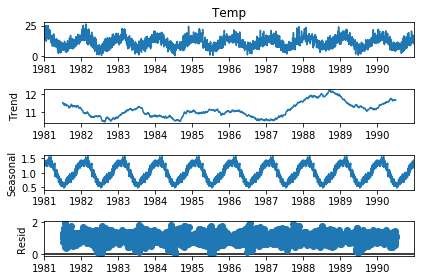

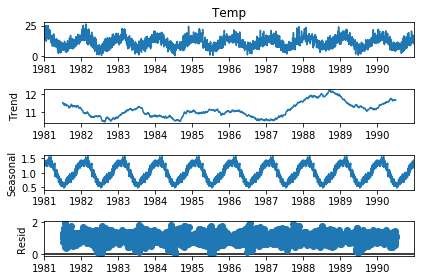

In [8]:
data_modified = data.replace(data.Temp[data.Temp <= 0].tolist(), 1)
data_modified[data_modified.Temp == 1]
sd(data_modified.Temp, model='multiplicative', period=365).plot()

In [9]:
avail_months = list(data.groupby(data.index.to_series().dt.month).groups.keys()) # Since .groups returns  dict, get all month names by dict.keys()
month_names = calendar.month_name[avail_months[0] : avail_months[-1]+1] # calendar.month_name[] receives only integer or slices [n:m]

each_monthly_Temp_avg = list(round(data.groupby(data.index.to_series().dt.month).Temp.mean(), 3))
overall_monthly_Temp_avg = round(sum(each_monthly_Temp_avg) / len(data.groupby(data.index.to_series().dt.month)), 2)
seasonal_index = list(map(lambda x: round(x/overall_monthly_Temp_avg, 3), each_monthly_Temp_avg))

pd.DataFrame({
    'each_monthly_Temp_avg' : each_monthly_Temp_avg,
    'overall_monthly_Temp_avg' : overall_monthly_Temp_avg,
    'seasonal_index' : seasonal_index,
    'Temp in next Year (1991)' : list(map(lambda x : x*15, seasonal_index)) # 15 is an init_forecast
}, index=month_names)

,each_monthly_Temp_avg,overall_monthly_Temp_avg,seasonal_index,Temp in next Year (1991)
January,15.021,11.2,1.341,20.115
February,15.374,11.2,1.373,20.595
March,14.565,11.2,1.300,19.500
April,12.088,11.2,1.079,16.185
May,9.866,11.2,0.881,13.215
June,7.278,11.2,0.650,9.750
July,6.693,11.2,0.598,8.970
August,7.891,11.2,0.705,10.575
September,8.976,11.2,0.801,12.015
October,10.309,11.2,0.920,13.800


* **TREND available**

From plot below, this dataset has a **seasonality and positive forward trend**.
<br>Therefore, Seasonal Index's acquired by the average of **CENTERED MOVING AVERAGE (CMA)** per available quarter.

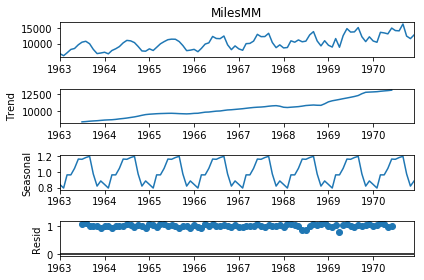

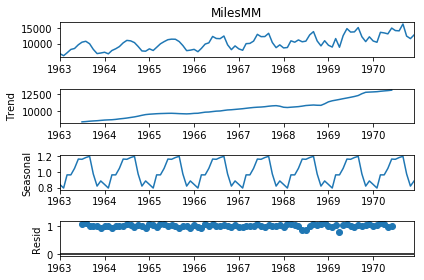

In [10]:
sample = pd.read_csv('Data/us-airlines-monthly-aircraft-miles-flown.csv', parse_dates=[0], index_col=0)
sd(sample.MilesMM, model='multiplicative').plot()

## Centered Moving Average Smoothing

In [11]:
def centered_moving_avg(series):
    cma = []
    for i in range(len(series)):
        try:
            if i-2 < 0: # to prevent negative index (avoid circular index)
                cma.append(None)
                continue
            else: cma.append(round(((.5 * series[i-2]) + series[i-1] + series[i] + series[i+1] + (.5 * series[i+2])) / 4, 2))
        except IndexError: # if index > len(series), to prevent IndexError when calculate series[i+1] and .5 * series[i+2]
            cma.append(None)
    return cma

In [12]:
def seasonal_index_based_on_CMA(data, s_ratio):
    if isinstance(data, pd.DatetimeIndex) == False: # check if the passed data is in type of DatetimeIndex
        raise TypeError("Oops! Expected passing DatetimeIndex type only, got {} type instead.".format(type(data)))
    
    # Get quartal months
    data = data.to_series().dt.month.tolist()
    
    # Get total of seasonal ratio per quartal (while None value removed)
    quartal_1 = list(filter(None, [s_ratio[i] for i in range(0, len(s_ratio), 4)]))
    quartal_2 = list(filter(None, [s_ratio[i] for i in range(1, len(s_ratio), 4)]))
    quartal_3 = list(filter(None, [s_ratio[i] for i in range(2, len(s_ratio), 4)]))
    quartal_4 = list(filter(None, [s_ratio[i] for i in range(3, len(s_ratio), 4)]))
    
    # Get seasonal index for each quartal
    seasonal_idx_q1 = round(sum(quartal_1) / len(quartal_1), 2)
    seasonal_idx_q2 = round(sum(quartal_2) / len(quartal_2), 2)
    seasonal_idx_q3 = round(sum(quartal_3) / len(quartal_3), 2)
    seasonal_idx_q4 = round(sum(quartal_4) / len(quartal_4), 2)
    
    # Sum of all seasonal index must be equal to number of season, which is 4 in this quartal case
    seasonal_idx_total = round(int(seasonal_idx_q1+seasonal_idx_q2+seasonal_idx_q3+seasonal_idx_q4))
    if seasonal_idx_total != 4:
        warnings.warn("The total value of seasonal indices must be equal to number of QUARTAL season == 4, got {} instead.".format(seasonal_idx_total))
    
    seasonal_idx_list = []
    for i in range(len(s_ratio)):
        if data[i] == 3: seasonal_idx_list.append(seasonal_idx_q1)
        elif data[i] == 6: seasonal_idx_list.append(seasonal_idx_q2)
        elif data[i] == 9: seasonal_idx_list.append(seasonal_idx_q3)
        else: seasonal_idx_list.append(seasonal_idx_q4)
    
    return seasonal_idx_list

In [13]:
# These five lines calculation represent on the table below
quarterly_sample = round(sample.resample(rule='Q').mean(), 2)
cma = centered_moving_avg(quarterly_sample.MilesMM)
seasonal_ratio = list(map(lambda x, y: None if(y==None) else round(x/y, 2), quarterly_sample.MilesMM, cma))
seasonal_idx = seasonal_index_based_on_CMA(quarterly_sample.index, seasonal_ratio)
deseasonalization = list(map(lambda x, y: None if(y==None) else round(x/y, 2), quarterly_sample.MilesMM, seasonal_idx))

# These two lines use for plotting result on the next cell
x_axis = np.array([i for i in range(1, len(quarterly_sample.index)+13)]).reshape(-1, 1) # +13 means from period 1-44 (4 actual quarters and 3 quarters for forecast)
y_axis = quarterly_sample.MilesMM.tolist()

pd.DataFrame({
    'quarterly_MilesMM' : quarterly_sample.MilesMM,
    'CMA' : cma,
    'seasonal_ratio' : seasonal_ratio,
    'seasonal_index_CMA' : seasonal_idx,
    'deseasonalized_MilesMM' : deseasonalization
})

,quarterly_MilesMM,CMA,seasonal_ratio,seasonal_index_CMA,deseasonalized_MilesMM
Month,,,,,
1963-03-31,6696.33,NaN,NaN,0.87,7696.93
1963-06-30,8756.00,NaN,NaN,1.06,8260.38
1963-09-30,10392.33,8374.17,1.24,1.18,8807.06
1963-12-31,7356.33,8507.25,0.86,0.90,8173.70
1964-03-31,7287.67,8610.92,0.85,0.87,8376.63
1964-06-30,9229.33,8752.37,1.05,1.06,8706.92
1964-09-30,10748.33,8980.37,1.20,1.18,9108.75
1964-12-31,8132.00,9284.37,0.88,0.90,9035.56
1965-03-31,8336.00,9508.79,0.88,0.87,9581.61


### <font color="red"> Forecast Accuracy / Error Evaluation</font>

In [14]:
reg = lr(normalize=True).fit(x_axis[:32], deseasonalization)
# Normalize feature (quarterly_sample.MilesMM)
norm1 = mms().fit_transform(np.array(y_axis).reshape(-1, 1))
normalized_y_actual = np.reshape(norm1, 32).tolist()
norm2 = mms().fit_transform(np.array(reg.predict(x_axis[:32]).reshape(-1, 1)))
normalized_y_predict = np.reshape(norm2, 32).tolist()

In [15]:
manual_rsfe = list(map(lambda a, b: a-b, normalized_y_actual, normalized_y_predict))
manual_rsfe = list(map(lambda n: round(n, 2), manual_rsfe)) # round each RSFE
manual_mad = list(mae([normalized_y_actual], [normalized_y_predict], multioutput='raw_values')**2)
manual_mad = list(map(lambda n: round(n, 2), manual_mad)) # round each MAD
manual_tracking_signal = list(map(lambda a, b: 0 if(b==0) else round(a/b, 2), manual_rsfe, manual_mad))

pd.DataFrame({
    'actual_y': y_axis,
    'predict_y': reg.predict(x_axis[:32]),
    'actual_y_norm': normalized_y_actual,
    'predict_y_norm': normalized_y_predict,
    'RSFE': manual_rsfe,
    'MAD': manual_mad,
    'Tracking Signal': manual_tracking_signal
}) # The manual results seem far different from sklearn function due to different approximation approach

,actual_y,predict_y,actual_y_norm,predict_y_norm,RSFE,MAD,Tracking Signal
0,6696.33,7850.524943,0.000000,0.000000,0.00,0.00,0.00
1,8756.00,8012.245592,0.253768,0.032258,0.22,0.05,4.40
2,10392.33,8173.966241,0.455378,0.064516,0.39,0.15,2.60
3,7356.33,8335.686890,0.081317,0.096774,-0.02,0.00,0.00
4,7287.67,8497.407538,0.072858,0.129032,-0.06,0.00,0.00
5,9229.33,8659.128187,0.312086,0.161290,0.15,0.02,7.50
6,10748.33,8820.848836,0.499240,0.193548,0.31,0.09,3.44
7,8132.00,8982.569485,0.176886,0.225806,-0.05,0.00,0.00
8,8336.00,9144.290134,0.202021,0.258065,-0.06,0.00,0.00
9,10613.00,9306.010783,0.482566,0.290323,0.19,0.04,4.75


In [16]:
def forecast_eval(actual, predict, x_axis=None):
    if isinstance(actual, list) == False: raise TypeError("Actual values must in the form of list, got {} type instead.".format(type(actual)))
    if isinstance(predict, list) == False: raise TypeError("Predicted values must in the form of list, got {} type instead.".format(type(predict)))
    
    # Normalization
    actual = mms().fit_transform(np.array(actual).reshape(-1, 1))
    actual = np.reshape(actual, len(actual)).tolist()
    predict = mms().fit_transform(np.array(predict).reshape(-1, 1))
    predict = np.reshape(predict, len(predict)).tolist()
    
    # Forecast Error
    forecast_error = list(map(lambda a, b: a-b, actual, predict))

    # Forecast Accuracy
    mean_squared_error = round(mse(actual, predict) * 100, 2)
    mean_absolute_error = round(mae(actual, predict) * 100, 2)
    mean_percentage_error = round((100 / len(y_axis)) * sum(list(map(lambda x, y: 0 if(y==0) else x/y, forecast_error, actual))), 2)
    mean_absolute_percentage_error = round((100 / len(y_axis)) * sum(list(map(lambda x, y: 0 if(y==0) else abs(x/y), forecast_error, actual))), 2)
    rsfe = round(sum(forecast_error), 2)
    tracking_signal = round(rsfe / mean_absolute_error, 2)

    # Regression Accuracy
    if x_axis is not None:
        # Preprocessing: Reshape x_axis if it's not in form of numpy.ndarray with ndim == 2
        if isinstance(x_axis, np.ndarray) == False:
            x_axis = np.array(x_axis)  
            if x_axis.ndim != 2:
                x_axis = np.array(x_axis).reshape(-1, 1)
        
        reg = lr(normalize=True).fit(x_axis, actual)
        rsquared = round(reg.score(x_axis, actual) * 100, 2)
    else:
        rsquared = None
    
    result = dict({
        "error": rsfe,
        "rsquared": rsquared,
        "mse": mean_squared_error,
        "mae": mean_absolute_error,
        "mpe": mean_percentage_error,
        "mape": mean_absolute_percentage_error,
        "tracking_signal": tracking_signal
    })
    
    return dot(result) # dict-key accessible with dot, e.g. forecast_eval().mae will return mean_absolute_error

In [17]:
evaluate = forecast_eval(normalized_y_actual, normalized_y_predict, x_axis[:32])
evaluate

{'error': -1.45,
 'rsquared': 55.23,
 'mse': 4.25,
 'mae': 17.27,
 'mpe': -19.02,
 'mape': 46.84,
 'tracking_signal': -0.08}

In [18]:
def forecast_plot(forecasted_data=False, regline=False, tracksig=False):
    plt.title("FORECAST for the next three quarters with evaluation: \n" +
        "R-Squared={}% / MSE={}% / MAD={}% / \n MPE={}% / MAPE={}% / RSFE={} \n TrackingSignal={}% (interval {} to +{} MADs)".format(
            evaluate.rsquared,
            evaluate.mse,
            evaluate.mae,
            evaluate.mpe,
            evaluate.mape, 
            evaluate.error,
            evaluate.tracking_signal,
            min(manual_tracking_signal),
            max(manual_tracking_signal)
        )
    )
    
    # Plot actual values
    plt.scatter(x_axis[:32], y_axis, color="xkcd:turquoise green")
    plt.plot(x_axis[:32], y_axis, 'xkcd:turquoise green', label="Actual Seasonal Trend")
    plt.scatter(x_axis[:32], deseasonalization, color="xkcd:yellowish orange")
    plt.plot(x_axis[:32], deseasonalization, 'xkcd:yellowish orange', label="Deseasonalized Trend")
    if regline: plt.plot(x_axis[:32], reg.predict(x_axis[:32]), 'xkcd:violet', label="Deseasonalized Regression")

    # Forecast for next year (1971)
    predict = reg.predict(x_axis[32:]) # for the 5th quarter (33-36)
    forecast_by_trend = list(map(lambda x, y: x * y, predict, seasonal_idx))
    if forecasted_data:
        plt.scatter(x_axis[32:], forecast_by_trend, color="xkcd:light blue green")
        plt.plot(x_axis[32:], forecast_by_trend, "xkcd:light blue green", label="Forecast Data")
    plt.plot(x_axis[32:], predict, 'k--', label="Forecast Regression")

    if tracksig:  
        # Plot ACCEPTABLE RANGE of Tracking Signal
        mts = np.array([min(manual_tracking_signal), evaluate.tracking_signal, max(manual_tracking_signal)]).reshape(-1, 1)
        adj_mts = mms((min(y_axis), max(y_axis))).fit_transform(mts) # adjust min/max of Tracking Value for plotting (while y-axis is actual_y)
        tracking_signal_range = np.reshape(adj_mts, 3).tolist()
        plt.hlines(tracking_signal_range[0], x_axis[0], x_axis[-1], colors="red", linestyles="dotted", label="Lower/Upper Control Limit") # plot Lower Control Limit line (min. range of Tracking Signal)
        plt.hlines(tracking_signal_range[1],x_axis[0], x_axis[-1], colors="xkcd:bright blue", linestyles="dashdot", label="Tracking Signal") # plot Tracking Signal acceptable line
        plt.hlines(tracking_signal_range[2], x_axis[0], x_axis[-1], colors="red", linestyles="dotted") # plot Upper Control Limit line (max. range of Tracking Signal)
        print("The tracking signal = {} is within the acceptable limits, between {} MADs to +{} MADs.".format(evaluate.tracking_signal, min(manual_tracking_signal), max(manual_tracking_signal)))

    plt.legend(bbox_to_anchor=(1.02,1), loc="best")

The tracking signal = -0.08 is within the acceptable limits, between -7.5 MADs to +9.0 MADs.


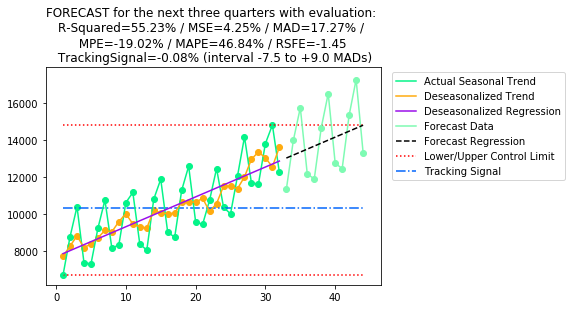

In [19]:
forecast_plot(forecasted_data=True, regline=True, tracksig=True) # change to FALSE if necessary

## Seasonal Decomposition

### <font color="red">WARNING OF USE</font>
>**statsmodels.tsa.seasonal.seasonal_decompose** requires a <font color="green">**COMPLETE**</font>**\*** time-series Datetime Index. Otherwise, it'll produce <font color="red">**ValueError: "You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None"**</font>. Therefore, it's highly recommended to do **time series data preprocessing** first (resample), or just set **.seasonal_decompose(..., period=(int))**.

>Sometimes due to longer time series data, your **.seasonal_decompose().plot()** seems flat or highly dense. To rectify this, try to add another parameter **.seasonal_decompose(..., period=(int))**. Usually period=365 to denotes a year period.

>To prevent <font color="red">**ValueError: Multiplicative seasonality is not appropriate for zero and negative values**</font> message on **.seasonal_decomposition(..., model="multiplicative")**, make sure all Series values **>= 0**.

**\*** *total days must be exact with its corresponding month in its corresponding year (so do consider the leap year)*

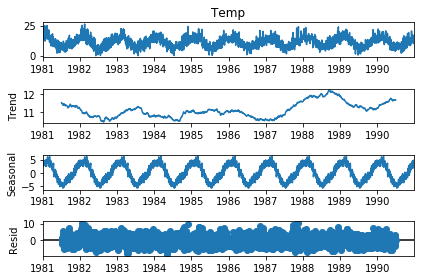

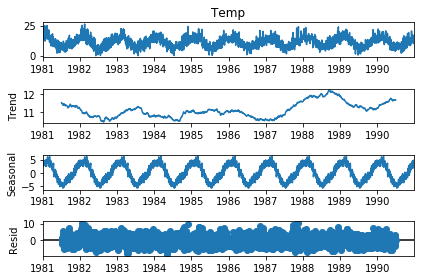

In [20]:
sd(data.Temp, model="additive", period=365).plot()

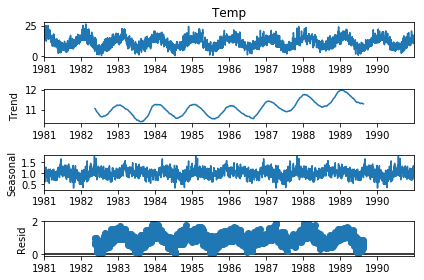

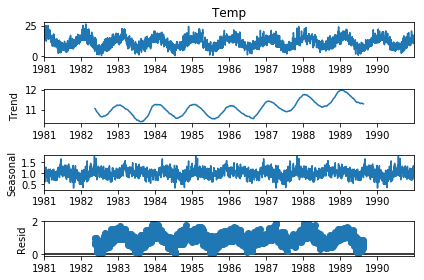

In [21]:
# Replace values <= 0 with 1 to do multiplicative seasonal decomposition
data_modified = data.replace(data.Temp[data.Temp <= 0].tolist(), 1)
data_modified[data_modified.Temp == 1]

sd(data_modified.Temp, model="multiplicative", period=1000).plot()

## Trend Projection - Inter/Extrapolation

## Auto Regressive Moving Average (ARMA)

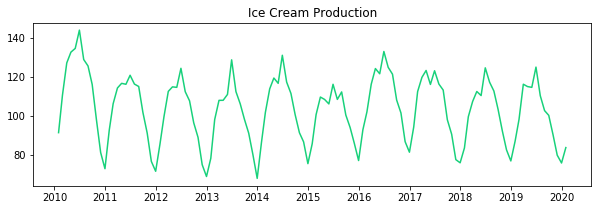

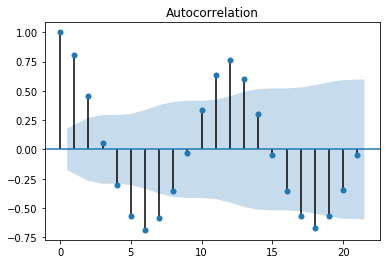

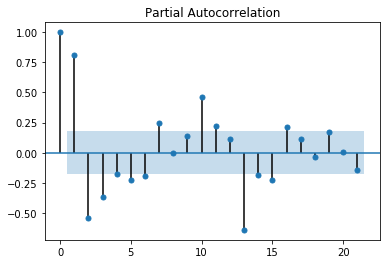

In [22]:
ice = pd.read_csv("Data/ice_cream.csv", parse_dates=[0], index_col=[0]).resample('M').sum() # Resample to monthly data
ice = ice[pd.to_datetime('2010-01-01'):] # Select dataset only from year 2010 above

plt.figure(figsize=(10, 3)) # Expand the figure size by width=10 and height=3
plt.plot(ice, "xkcd:seaweed") # Plot the actual dataset with green line
plt.title("Ice Cream Production") # Set a title above the plot
plot_acf(ice); plot_pacf(ice); # Everything within the blue area is NOT statistically significant

In [23]:
# Split dataset into Training:Testing = 80:20
split = int(.8 * len(ice))
train_data , test_data = ice[:split], ice[split:]

In [24]:
arma_model = ARMA(train_data, order=(7, 2)).fit() # Try to change the order p in order(p, q) parameter
arma_model.summary()
# Column "P>|z|" indicates the p-value. If p-value < .05, then it's statistically significant
# From ARMA(7, 3) result: only ar.L6, ar.L7, and ma.L3t are statistically significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              IPN31152N   No. Observations:                   96
Model:                     ARMA(7, 2)   Log Likelihood                -321.119
Method:                       css-mle   S.D. of innovations              6.701
Date:                Tue, 02 Jun 2020   AIC                            664.237
Time:                        11:34:04   BIC                            692.445
Sample:                    01-31-2010   HQIC                           675.639
                         - 12-31-2017                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             104.4300      2.089     50.001      0.000     100.336     108.523
ar.L1.IPN31152N     1.3412      0.159      8.447      0.000       1.030       1.652
ar.L2.IPN31152N    -0.2101      0.246     -0.854      0.393      -0.692       0.272
ar.L3.IPN31152N    -0.5168      0.184     -2.806      0.005      -0.878      -0.156
ar.L4.IPN31152N     0.2867      0.162      1.772      0.076      -0.030       0.604
ar.L5.IPN31152N     0.1188      0.153      0.776      0.438      -0.181       0.419
ar.L6.IPN31152N    -0.6092      0.153     -3.974      0.000      -0.910      -0.309
ar.L7.IPN31152N     0.4870      0.094      5.177      0.000       0.303       0.671
ma.L1.IPN31152N    -0.3940      0.169     -2.338      0.019      -0.724      -0.064
ma.L2.IPN31152N    -0.2900      0.130     -2.231      0.026      -0.545      -0.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0073           -0.5210j            1.1341           -0.4240
AR.2           -1.0073           +0.5210j            1.1341            0.4240
AR.3            0.2025           -1.1695j            1.1869           -0.2227
AR.4            0.2025           +1.1695j            1.1869            0.2227
AR.5            0.8850           -0.5060j            1.0194           -0.0827
AR.6            0.8850           +0.5060j            1.0194            0.0827
AR.7            1.0905           -0.0000j            1.0905           -0.0000
MA.1            1.2980           +0.0000j            1.2980            0.0000
MA.2           -2.6568           +0.0000j            2.6568            0.5000
-----------------------------------------------------------------------------
"""

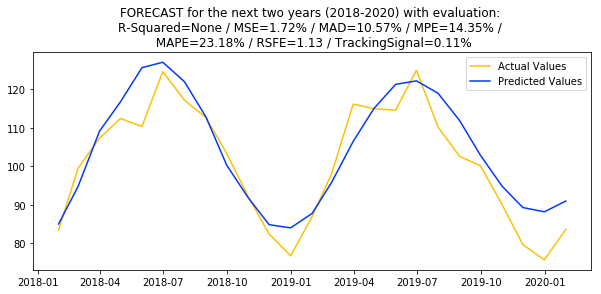

In [25]:
ice_predict = arma_model.predict(start=test_data.index[0], end=test_data.index[-1])
arma_eval = forecast_eval(test_data.IPN31152N.tolist(), ice_predict.tolist())

plt.figure(figsize=(10, 4)) # expand the figure size by width=10 and height=4
plt.title("FORECAST for the next two years (2018-2020) with evaluation: \n" +
    "R-Squared={} / MSE={}% / MAD={}% / MPE={}% / \n MAPE={}% / RSFE={} / TrackingSignal={}%".format(
        arma_eval.rsquared,
        arma_eval.mse,
        arma_eval.mae,
        arma_eval.mpe,
        arma_eval.mape, 
        arma_eval.error,
        arma_eval.tracking_signal
    )
)
plt.plot(test_data, 'xkcd:goldenrod', label="Actual Values") # plot the actual values
plt.plot(ice_predict, 'xkcd:vibrant blue', label="Predicted Values") # plot the predicted values
plt.legend(loc='best')

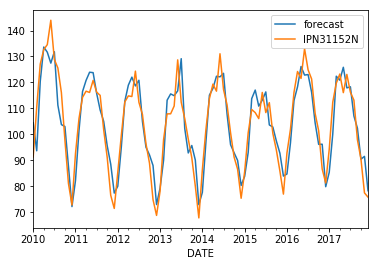

In [26]:
# Another way to compare the actual with predicted values
arma_model.plot_predict();

## Non-Seasonal Auto Regressive Integrated Moving Average (ARIMA)

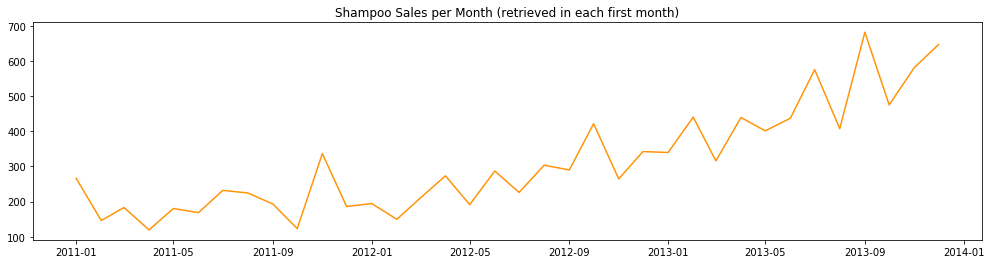

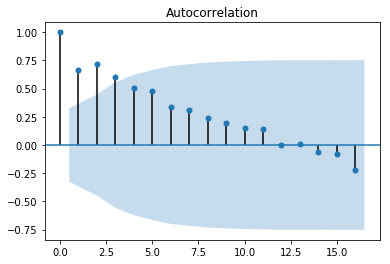

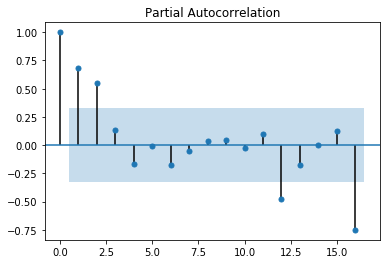

In [27]:
dateparse = lambda x: dt.datetime.strptime('201'+x, '%Y-%m') # assign format for Year-Month 
shampoo = pd.read_csv("Data/shampoo2.csv", date_parser=dateparse, index_col=[0]) # dataset loading
shampoo.index = pd.DatetimeIndex(shampoo.index.values, freq=shampoo.index.inferred_freq) # assign freq='...' for DatetimeIndex

plt.figure(figsize=(17, 4)) # Expand the figure size by width=17 and height=4
plt.plot(shampoo, "xkcd:tangerine") # Plot the actual dataset with orange line
plt.title("Shampoo Sales per Month (retrieved in each first month)") # Set a title above the plot
plot_acf(shampoo); plot_pacf(shampoo); # Everything within the blue area is NOT statistically significant

In [28]:
arima_model = ARIMA(shampoo, order=(2, 2, 3)).fit(disp=0) # order(p, d, q)
arima_model.summary()
# Column "P>|z|" indicates the p-value. If p-value < .05, then it's statistically significant
# From ARMA(7, 3) result: only ar.L6, ar.L7, and ma.L3t are statistically significant

c:\users\nicholas dominic\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Sales   No. Observations:                   34
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -187.842
Method:                       css-mle   S.D. of innovations             49.733
Date:                Tue, 02 Jun 2020   AIC                            389.683
Time:                        11:34:08   BIC                            400.368
Sample:                    03-01-2011   HQIC                           393.327
                         - 12-01-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9216      0.101      9.091      0.000       0.723       1.120
ar.L1.D2.Sales    -1.4817      0.138    -10.705      0.000      -1.753      -1.210
ar.L2.D2.Sales    -0.5608      0.139     -4.030      0.000      -0.833      -0.288
ma.L1.D2.Sales    -0.9867      0.147     -6.697      0.000      -1.275      -0.698
ma.L2.D2.Sales    -0.9872      0.155     -6.356      0.000      -1.292      -0.683
ma.L3.D2.Sales     0.9995      0.147      6.791      0.000       0.711       1.288
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3212           -0.1944j            1.3354           -0.4768
AR.2           -1.3212           +0.1944j            1.3354            0.4768
MA.1           -1.0000           -0.0000j            1.0000           -0.5000
MA.2            0.9938           -0.1132j            1.0003           -0.0180
MA.3            0.9938           +0.1132j            1.0003            0.0180
-----------------------------------------------------------------------------
"""

In [29]:
today = dt.datetime.today()
new_shampoo_timeindex = pd.date_range(start=shampoo.index[-1], end=str(today.year) + "-" + str(today.month), freq="MS")

shampoo_forecast = arima_model.forecast(len(new_shampoo_timeindex)) # forecast(n), where n = number of related period, default n = 1
# first array indicates the forecast value for next n-th period
# second array indicates standard error of forecast
# third array indicates confidence interval (95%)

forecast_shampoo_data = pd.DataFrame(shampoo_forecast[0], index=new_shampoo_timeindex, columns=["Sales"])
forecast_shampoo_data

,Sales
2013-12-01,615.457778
2014-01-01,691.325941
2014-02-01,685.357274
2014-03-01,743.277229
2014-04-01,755.226538
...,...
2020-02-01,5281.530328
2020-03-01,5378.790674
2020-04-01,5476.972663
2020-05-01,5576.076295


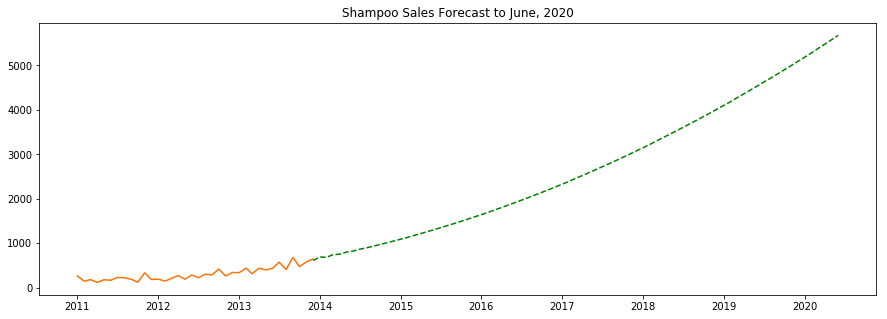

In [30]:
plt.figure(figsize=(15, 5))
plt.title("Shampoo Sales Forecast to {}, {}".format(calendar.month_name[today.month], today.year))
plt.plot(shampoo.Sales, "xkcd:orange") # plot actual data with green line
plt.plot(forecast_shampoo_data.Sales, "g--") # plot forecasted data with green dashline